# Stock Market Prediction using Python - Machine Learning

## Modules Installation
Please restart the kernel to use the installed modules inside notebook (Ignore if already installed!)

In [ ]:
pip install pandas

In [ ]:
pip install numpy

In [ ]:
pip install matplotlib

In [ ]:
pip install tensorflow

In [ ]:
pip install sklearn

In [ ]:
pip install pmdarima

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

# Data Initialization 
Data used here is from TATA Company

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

rcParams['figure.figsize'] = 30,20
scaler = MinMaxScaler(feature_range=(0, 1))

df = pd.read_csv('/content/Data.csv') #If showing error(s): Use the actual path of Data.csv file
df.head(10)

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05
5,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914.0,7162.35
6,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859.0,11859.95
7,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909.0,5248.60
8,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368.0,5503.90
9,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509.0,7999.55


# Plotting the Data Graph

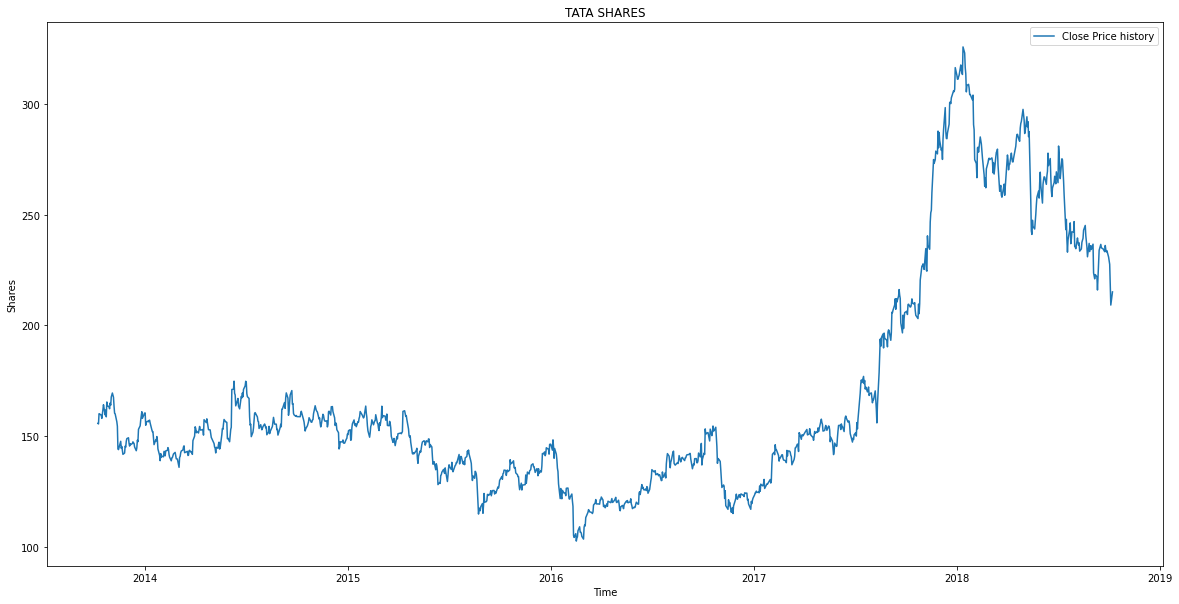

In [ ]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

plt.figure(figsize=(20,10))
plt.plot(df['Close'], label='Close Price history')
plt.title("TATA SHARES")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

# 1. Implementing K-N-N Method

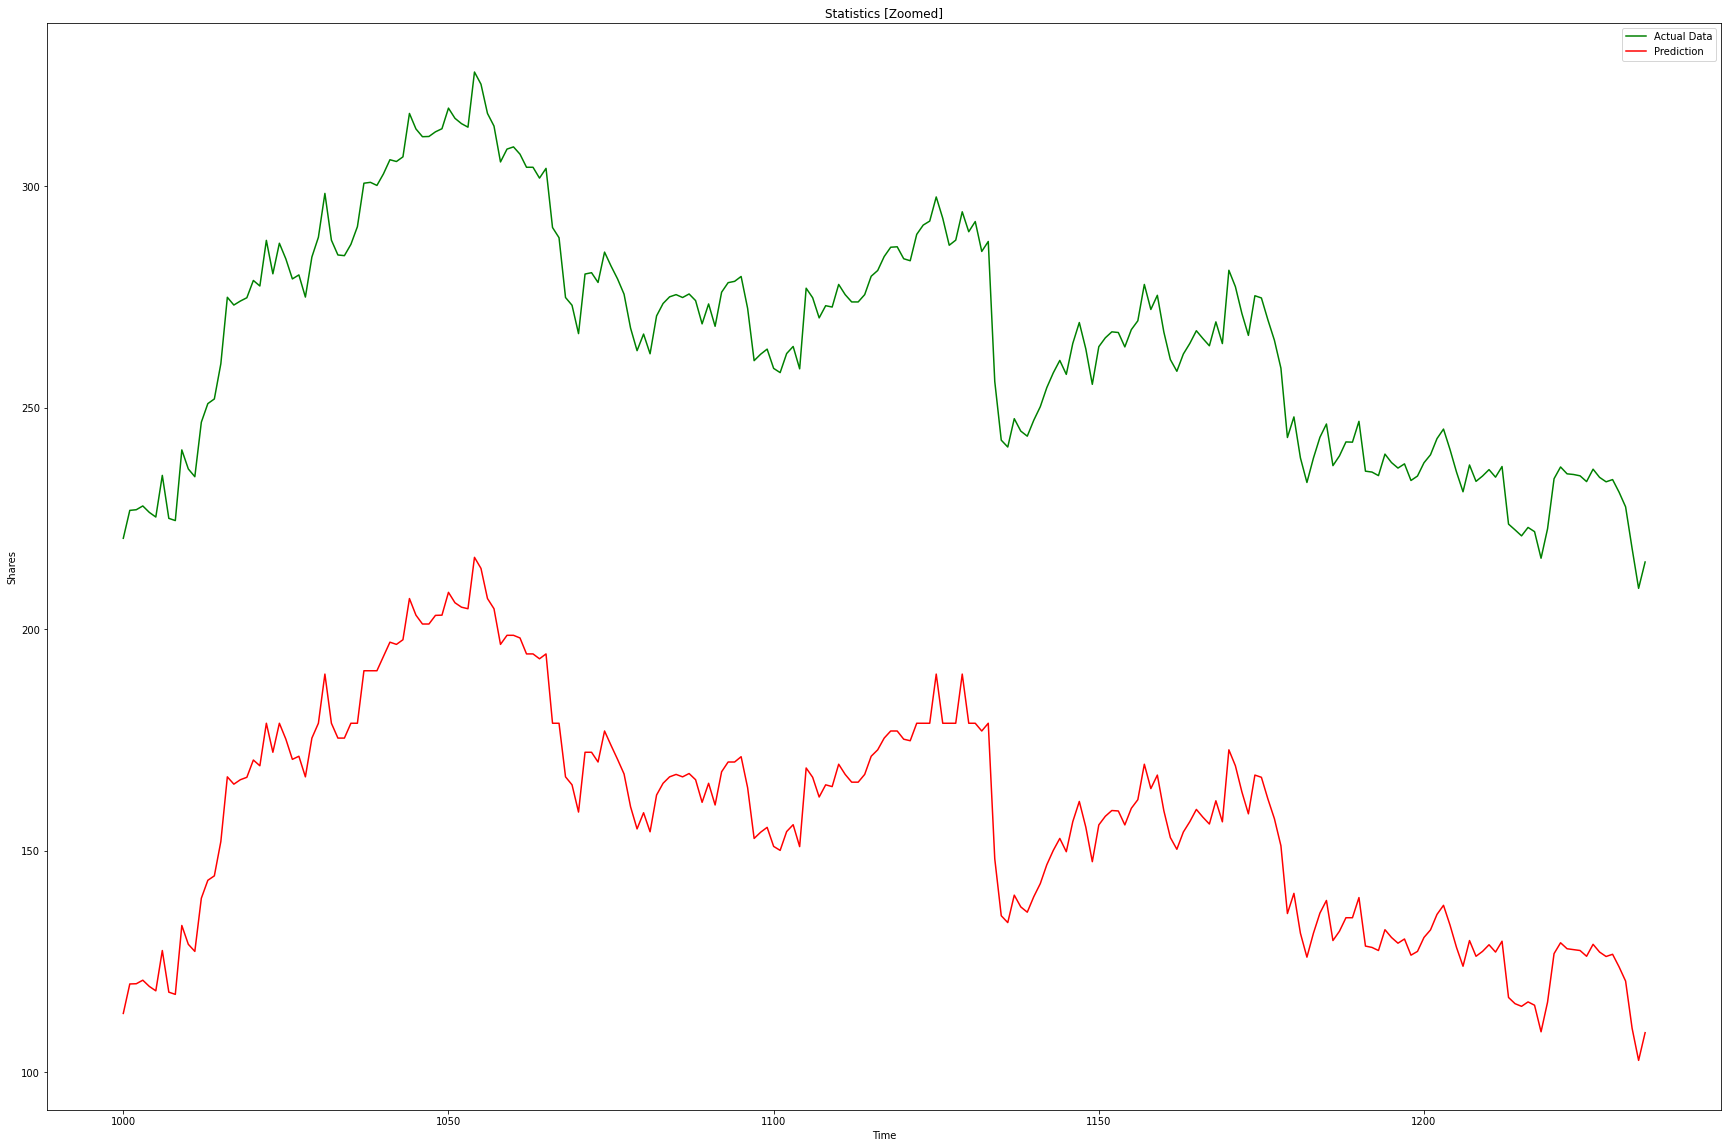

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

pd.set_option('mode.chained_assignment', None)

data = df.sort_index(ascending=True, axis=0)

new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
        
train = new_data[:1000]
valid = new_data[1000:]

x_train_scaled = scaler.fit_transform(train.drop('Date', axis=1))
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(valid.drop('Date', axis=1))
x_valid = pd.DataFrame(x_valid_scaled)

params = {'n_neighbors':[1,2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=8)

#Fitting the KNN model and making Data predictions
model.fit(x_train,train['Close'])
preds = model.predict(x_valid)
valid['Predictions'] = preds

#plotting estimated (prediction graph) for the trained value only
plt.plot(valid[['Close']], label="Actual Data", color="green")
plt.plot(valid[['Predictions']], label="Prediction", color="red")

plt.title("Statistics [Zoomed]")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

# Result Metrics for K-N-N Method (above)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_test_classes = np.zeros_like(valid['Close'].tolist())
y_test_classes[valid['Close'] > 250] = 1
y_test_classes[valid['Close'] < 200] = -1

y_pred_classes = np.zeros_like(valid['Predictions'].tolist())   
y_pred_classes[valid['Predictions'] > 250] = 1  
y_pred_classes[valid['Predictions'] < 200] = -1
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy: %.3f' % accuracy)
precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Precision: %.3f' % precision) 

recall = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Recall: %.3f' % recall) 

score = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('F-Measure: %.3f' % score) 

ME = max_error(valid['Close'], valid['Predictions'])
print('Max-Error: %.3f' % ME) 

MAE = mean_absolute_error(valid['Close'], valid['Predictions'])
print('Mean-Absolute-Error: %.3f' % MAE) 

MSE = mean_squared_error(valid['Close'], valid['Predictions'], squared=False)
print('Mean-Squared-Error: %.3f' % MSE) 

AUC = roc_auc_score(y_test_classes, y_pred_classes, average='macro')
print('AUC Score: %.3f' % AUC) 

CM = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n\n",CM)

Accuracy: 0.932
Precision: 0.934
Recall: 0.907
F-Measure: 0.919
Max-Error: 9914.452
Mean-Absolute-Error: 426.107
Mean-Squared-Error: 2044.565
AUC Score: 0.907

Confusion Matrix:

 [[ 63  12]
 [  4 156]]


# 2. Implementing Moving-Average Method

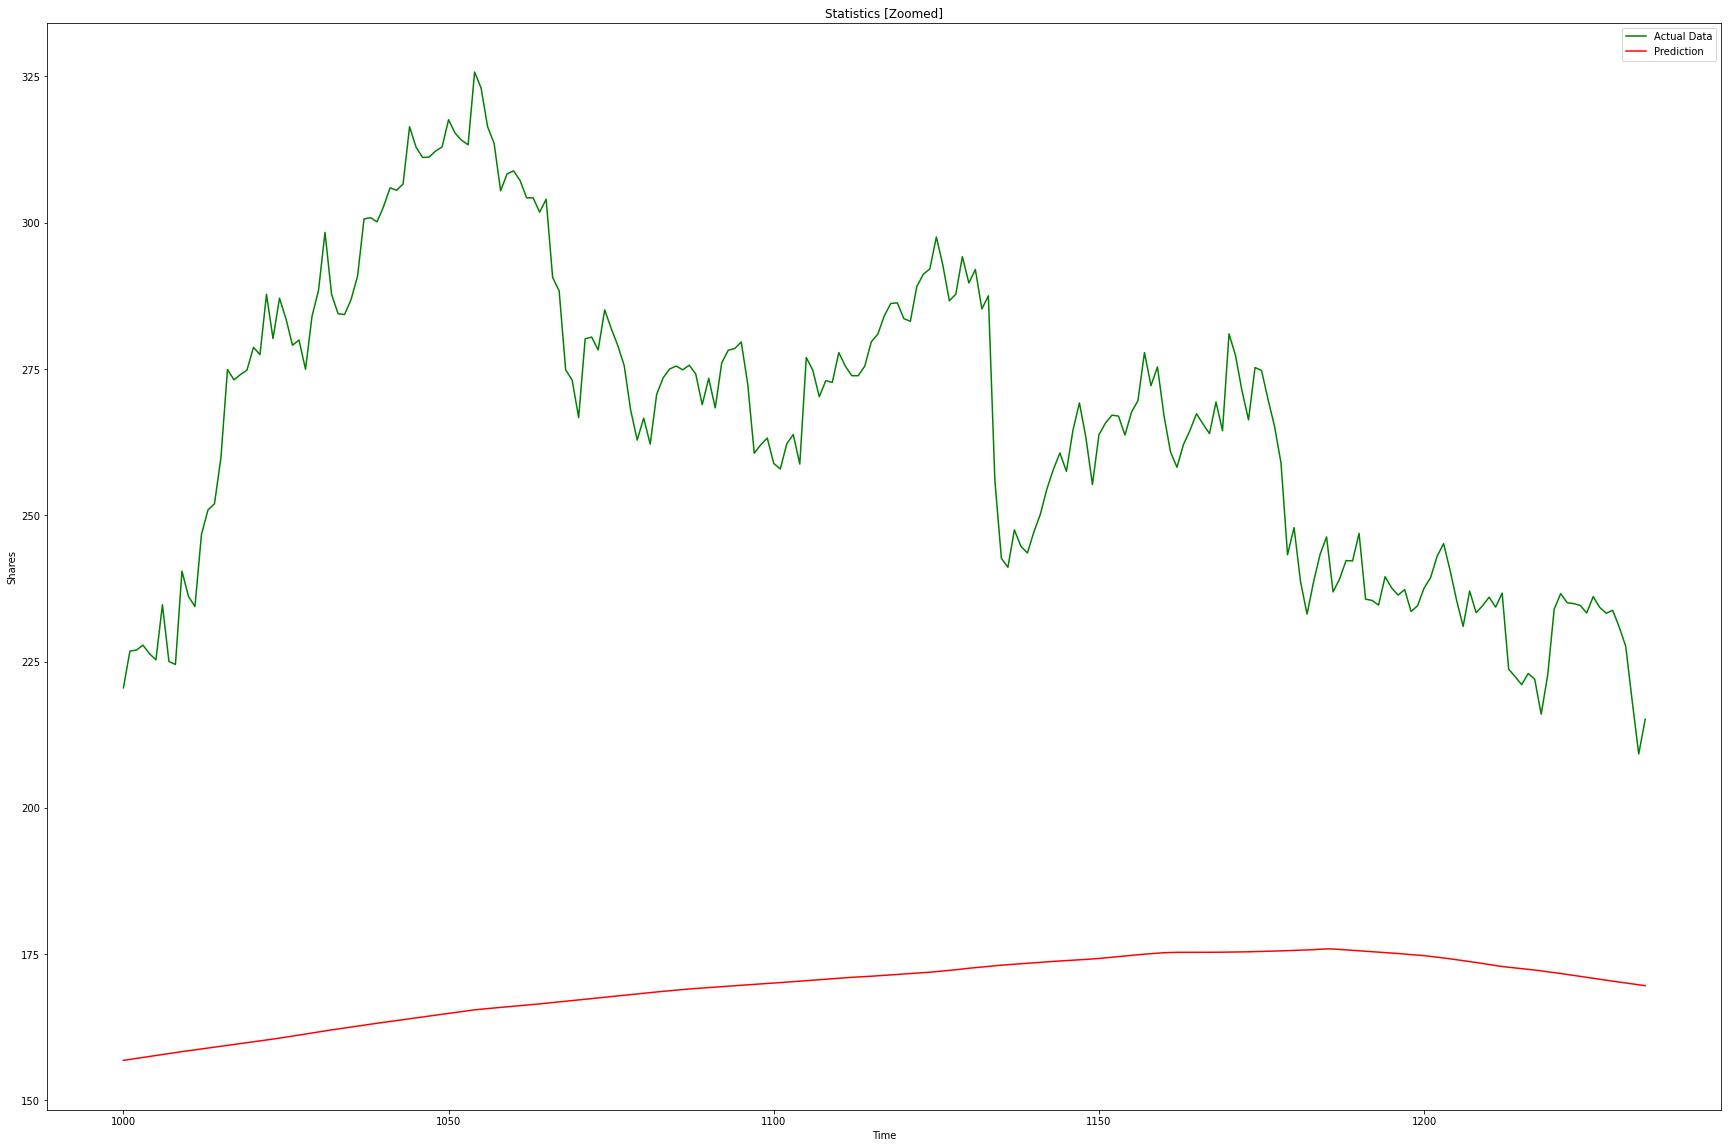

In [ ]:
preds = []
for i in range(0,valid.shape[0]):
    x = train['Close'][len(train)-valid.shape[0]+i:].sum() + sum(preds)
    y = x / valid.shape[0]
    preds.append(y)

valid['Predictions'] = preds

#plotting estimated (prediction graph) for the trained value only
plt.plot(valid[['Close']], label="Actual Data", color="green")
plt.plot(valid[['Predictions']], label="Prediction", color="red")

plt.title("Statistics [Zoomed]")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

# Result Metrics for M-A Method (above)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
y_test_classes = np.zeros_like(valid['Close'].tolist())
y_test_classes[valid['Close'] > 250] = 1
y_test_classes[valid['Close'] < 200] = -1

y_pred_classes = np.zeros_like(valid['Predictions'].tolist())   
y_pred_classes[valid['Predictions'] > 250] = 1  
y_pred_classes[valid['Predictions'] < 200] = -1
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy: %.3f' % accuracy)
precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Precision: %.3f' % precision) 

recall = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Recall: %.3f' % recall) 

score = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('F-Measure: %.3f' % score) 

ME = max_error(valid['Close'], valid['Predictions'])
print('Max-Error: %.3f' % ME) 

MAE = mean_absolute_error(valid['Close'], valid['Predictions'])
print('Mean-Absolute-Error: %.3f' % MAE) 

MSE = mean_squared_error(valid['Close'], valid['Predictions'], squared=False)
print('Mean-Squared-Error: %.3f' % MSE) 

AUC = roc_auc_score(y_test_classes, y_pred_classes, average='macro')
print('AUC Score: %.3f' % AUC) 

CM = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n\n",CM)

Accuracy: 0.932
Precision: 0.934
Recall: 0.907
F-Measure: 0.919
Max-Error: 9914.452
Mean-Absolute-Error: 426.107
Mean-Squared-Error: 2044.565
AUC Score: 0.907

Confusion Matrix:

 [[ 63  12]
 [  4 156]]


# 3. Implementing AUTO-ARIMA Method

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=4.49 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5564.537, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5240.524, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5566.403, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5145.602, Time=1.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=12.95 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.57 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5143.650, Time=1.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=5238.584, Time=0.55 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=9.73 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=3.46 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=5145.605, Time=2.00 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5147.280, Time=4.57 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=5145.

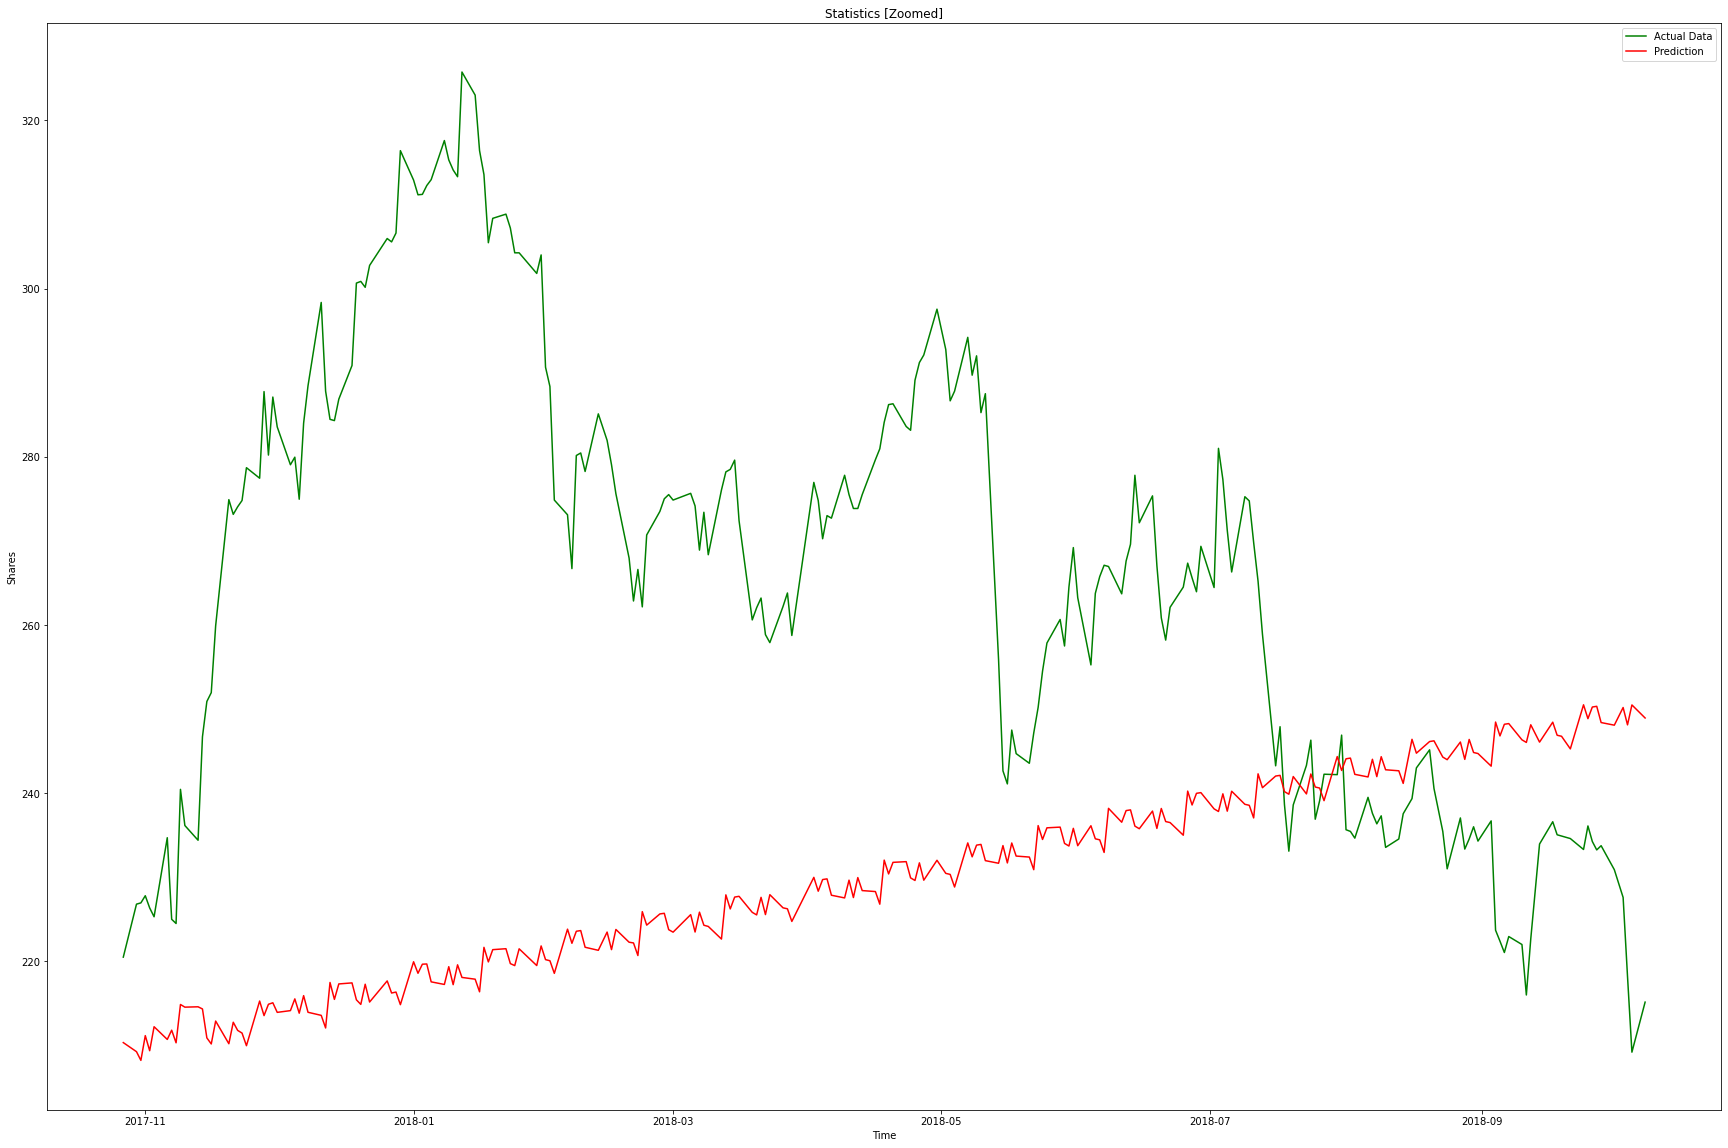

In [ ]:
from pmdarima import auto_arima

train = data[:1000]
valid = data[1000:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True,d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=235)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plotting estimated (prediction graph) for the trained value only
plt.plot(valid['Close'],label="Actual Data", color="green")
plt.plot(forecast['Prediction'], label="Prediction", color="red")

plt.title("Statistics [Zoomed]")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

# Result Metrics for A-A Method (above)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_test_classes = np.zeros_like(valid['Close'].tolist())
y_test_classes[valid['Close'] > 250] = 1
y_test_classes[valid['Close'] < 200] = -1

y_pred_classes = np.zeros_like(forecast['Prediction'].tolist())   
y_pred_classes[forecast['Prediction'] > 250] = 1  
y_pred_classes[forecast['Prediction'] < 200] = -1
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy: %.3f' % accuracy)

precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Precision: %.3f' % precision) 

recall = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Recall: %.3f' % recall) 

score = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('F-Measure: %.3f' % score) 

ME = max_error(valid['Close'], forecast['Prediction'])
print('Max-Error: %.3f' % ME) 

MAE = mean_absolute_error(valid['Close'], forecast['Prediction'])
print('Mean-Absolute-Error: %.3f' % MAE) 

MSE = mean_squared_error(valid['Close'], forecast['Prediction'], squared=False)
print('Mean-Squared-Error: %.3f' % MSE) 

AUC = roc_auc_score(y_test_classes, y_pred_classes, average='macro')
print('AUC Score: %.3f' % AUC) 

CM = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n\n",CM)

Accuracy: 0.298
Precision: 0.152
Recall: 0.467
F-Measure: 0.230
Max-Error: 107.664
Mean-Absolute-Error: 41.355
Mean-Squared-Error: 49.489
AUC Score: 0.467

Confusion Matrix:

 [[ 70   5]
 [160   0]]


# 4. Implementing Linear Regression Method

## Using features ('Date' , 'Close')

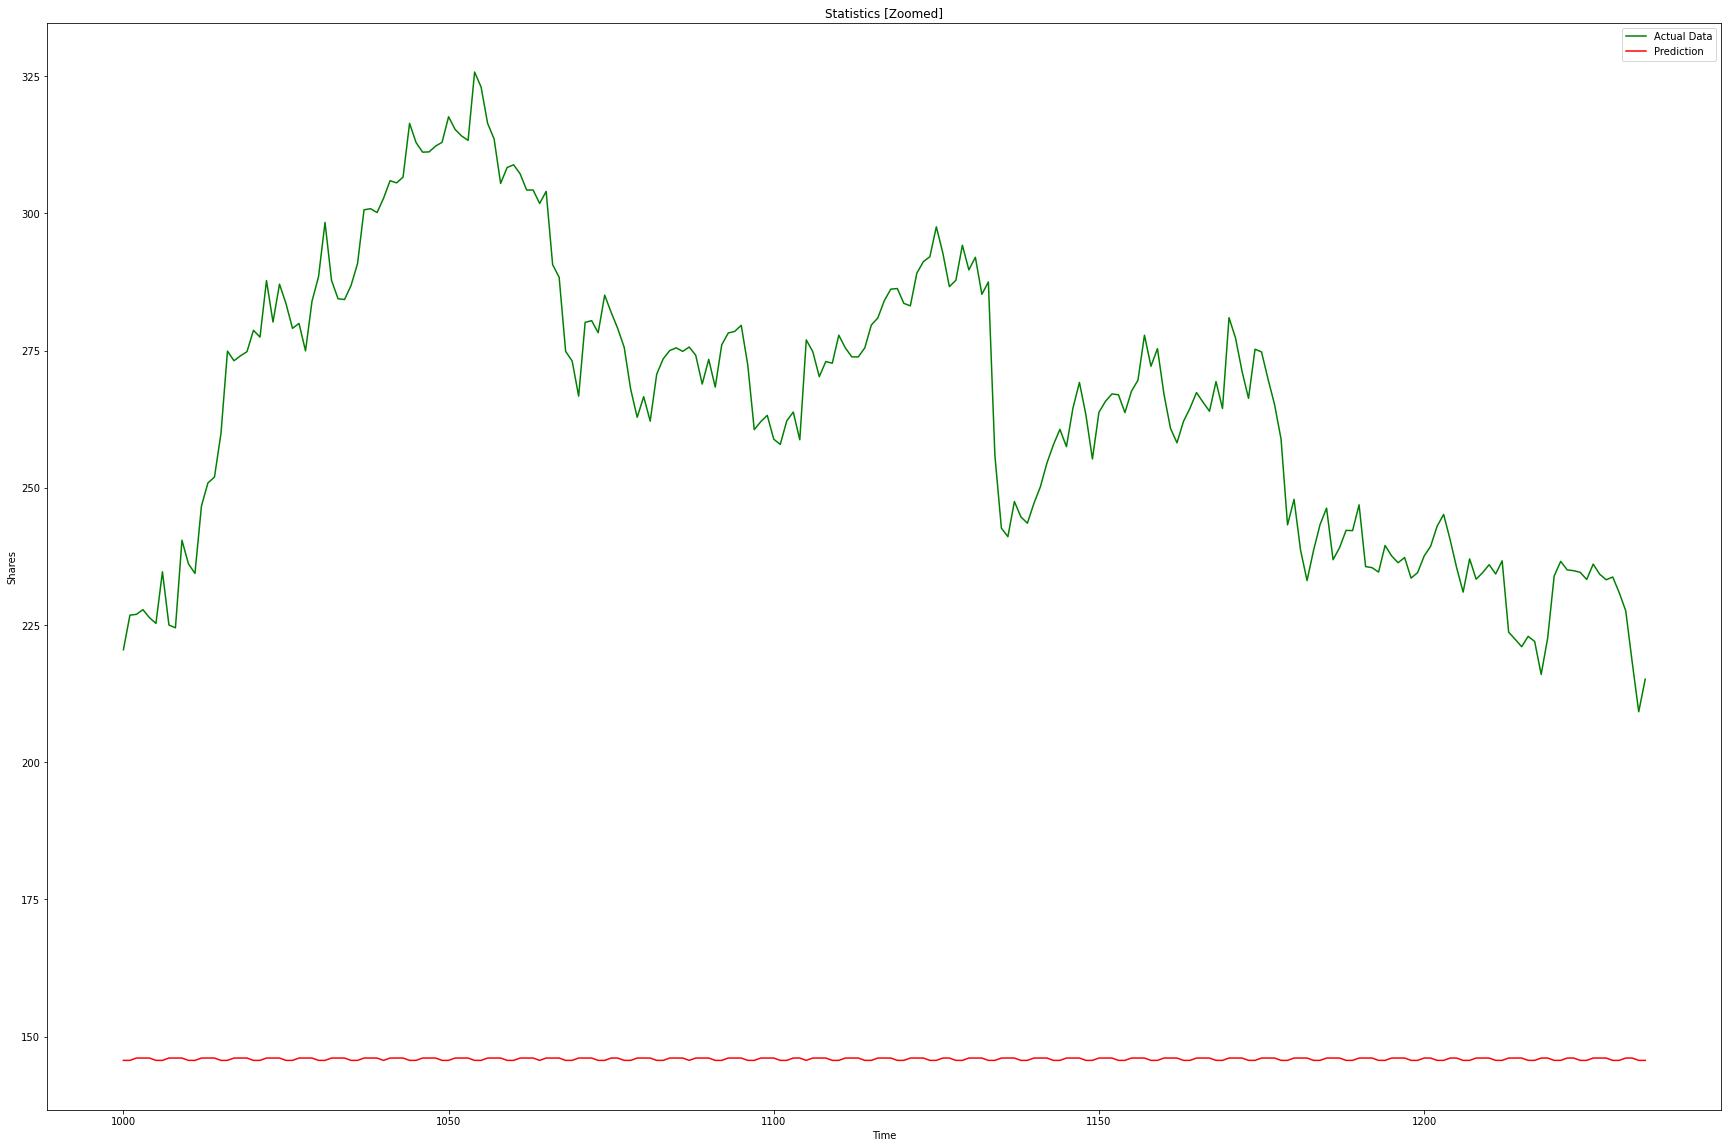

In [ ]:
from sklearn.linear_model import LinearRegression
import datetime
import calendar

new_data0 = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data0['Date'][i] = data['Date'][i]
    new_data0['Close'][i] = data['Close'][i]
    
train0 = new_data0[:1000]
valid0 = new_data0[1000:]

train0['Date1'] = 0
valid0['Date1'] = 0

for i in range (len(train)):
    if calendar.day_name[datetime.datetime.strptime(str(train0['Date'][i])[:10], '%Y-%m-%d').weekday()] in ['Monday','Friday']:
        train0['Date1'][i]=1
for i in range (1000,1000+len(valid)):
    if calendar.day_name[datetime.datetime.strptime(str(valid0['Date'][i])[:10], '%Y-%m-%d').weekday()] in ['Monday','Friday']:
        valid0['Date1'][i]=1

train0 = train0.drop('Date', axis=1)
valid0 = valid0.drop('Date', axis=1)

x_train = train0.drop('Close', axis=1)
y_train = train0['Close']
x_valid = valid0.drop('Close', axis=1)
y_valid = valid0['Close']

model = LinearRegression()
model.fit(x_train,y_train)
preds1 = model.predict(x_valid)

valid0['Predictions'] = preds1

valid0.index = new_data0[1000:].index
train0.index = new_data0[:1000].index

#plotting estimated (prediction graph) for the trained value only
plt.plot(valid0[['Close']], label="Actual Data", color="green")
plt.plot(valid0[['Predictions']], label="Prediction", color="red")

plt.title("Statistics [Zoomed]")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

## Using features ('Open' , 'Close')

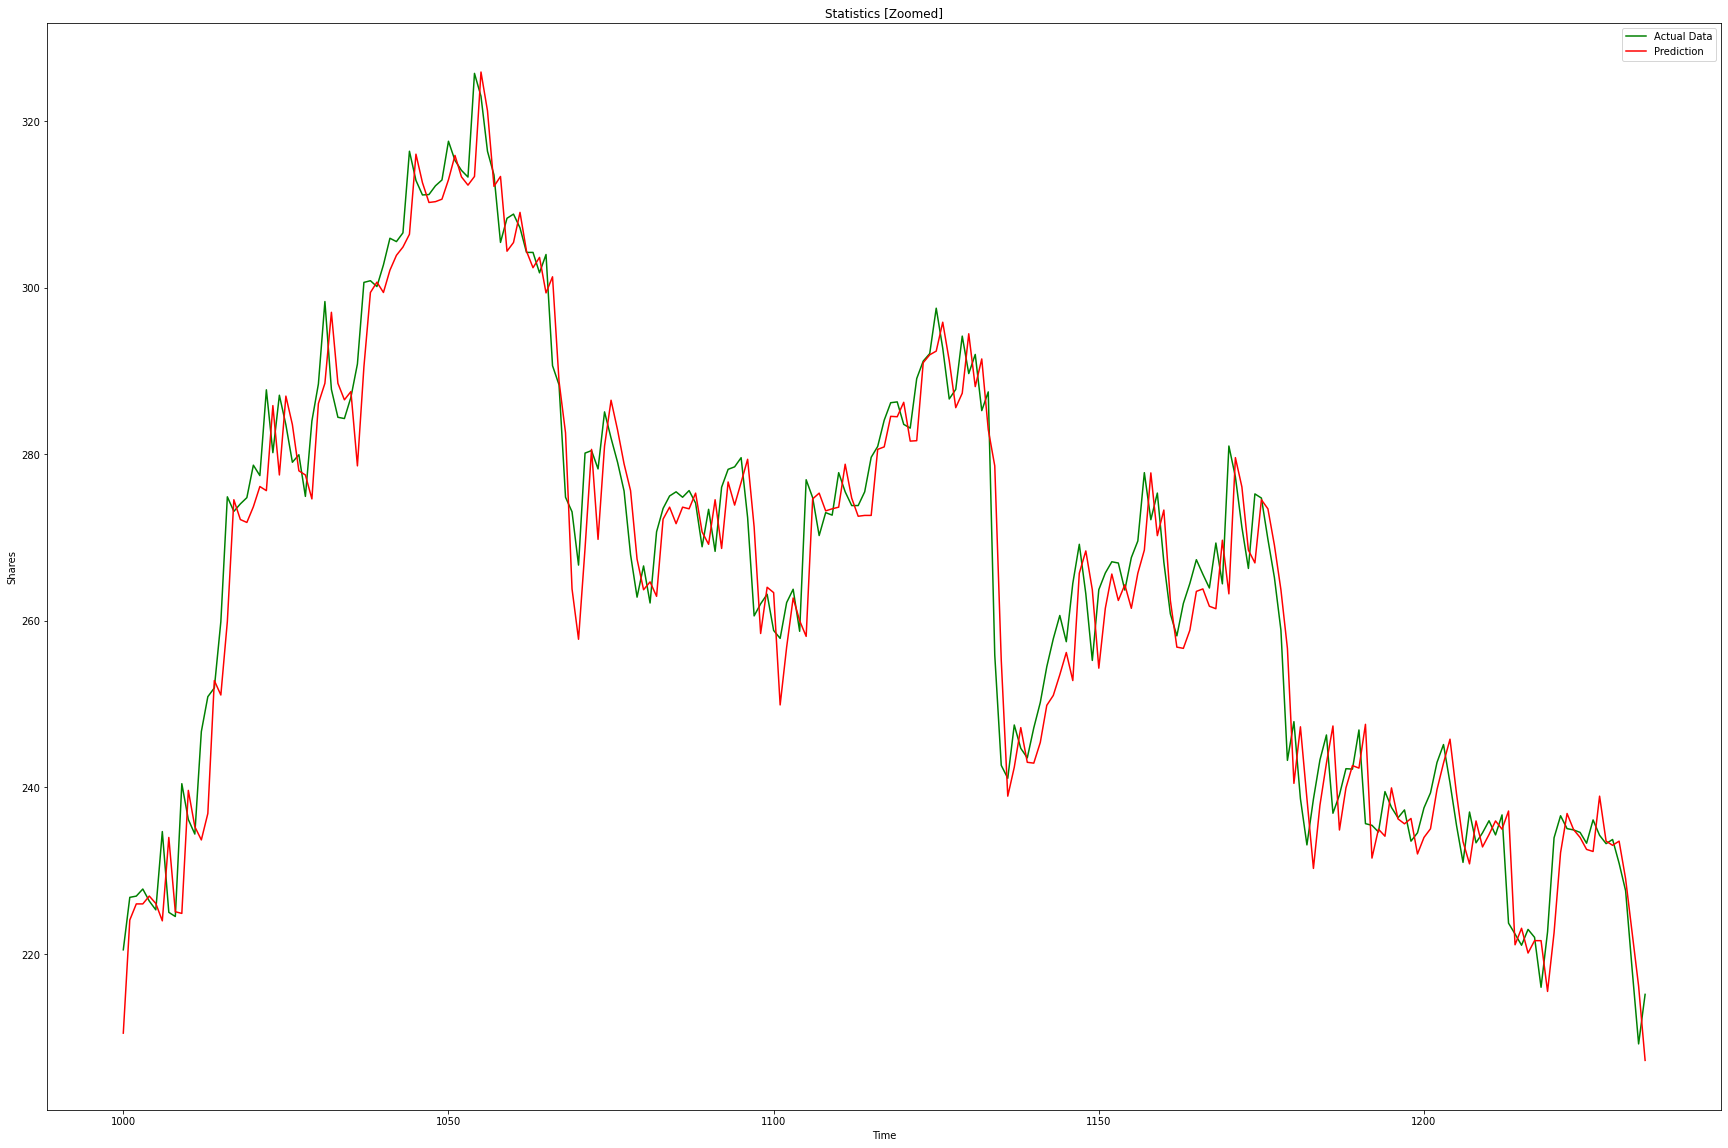

In [ ]:
from sklearn.linear_model import LinearRegression

new_data1 = pd.DataFrame(index=range(0,len(df)),columns=['Open', 'Close'])

for i in range(0,len(data)):
    new_data1['Open'][i] = data['Open'][i]
    new_data1['Close'][i] = data['Close'][i]
        
train1 = new_data1[:1000]
valid1 = new_data1[1000:]

x_train1 = train1.drop('Close', axis=1)
y_train1 = train1['Close']
x_valid1 = valid1.drop('Close', axis=1)
y_valid1 = valid1['Close']

model = LinearRegression()
model1 = LinearRegression()
model.fit(x_train1,y_train1)
preds11 = model.predict(x_valid1)

valid1['Predictions'] = preds11

valid1.index = new_data1[1000:].index
train1.index = new_data1[:1000].index

#plotting estimated (prediction graph) for the trained value only
plt.plot(valid1[['Close']], label="Actual Data", color="green")
plt.plot(valid1[['Predictions']], label="Prediction", color="red")

plt.title("Statistics [Zoomed]")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

# Result Metrics for L-R Method (above)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_test_classes = np.zeros_like(valid1['Close'].tolist())
y_test_classes[valid1['Close'] > 250] = 1
y_test_classes[valid1['Close'] < 200] = -1

y_pred_classes = np.zeros_like(valid1['Predictions'].tolist())   
y_pred_classes[valid1['Predictions'] > 250] = 1  
y_pred_classes[valid1['Predictions'] < 200] = -1

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy: %.3f' % accuracy)

precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Precision: %.3f' % precision) 

recall = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Recall: %.3f' % recall) 

score = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('F-Measure: %.3f' % score) 

ME = max_error(valid1['Close'], valid1['Predictions'])
print('Max-Error: %.3f' % ME) 

MAE = mean_absolute_error(valid1['Close'], valid1['Predictions'])
print('Mean-Absolute-Error: %.3f' % MAE) 

MSE = mean_squared_error(valid1['Close'], valid1['Predictions'], squared=False)
print('Mean-Squared-Error: %.3f' % MSE) 

AUC = roc_auc_score(y_test_classes, y_pred_classes, average='macro')
print('AUC Score: %.3f' % AUC) 

CM = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n\n",CM)

Accuracy: 0.974
Precision: 0.968
Recall: 0.974
F-Measure: 0.971
Max-Error: 22.715
Mean-Absolute-Error: 4.534
Mean-Squared-Error: 5.946
AUC Score: 0.974

Confusion Matrix:

 [[ 73   2]
 [  4 156]]


# 5. Implementing LSTM method

In [ ]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values

train = dataset[0:1000,:]
valid = dataset[1000:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train = []
y_train = []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Fitting the LSTM model and making Data predictions
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=15, batch_size=3, verbose=2)

# Using past 2 months data (60 days) --> predicting upcoming values (approx - 235 values)
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Epoch 1/15
314/314 - 15s - loss: 0.0012 - 15s/epoch - 49ms/step
Epoch 2/15
314/314 - 12s - loss: 5.7228e-04 - 12s/epoch - 38ms/step
Epoch 3/15
314/314 - 12s - loss: 4.5702e-04 - 12s/epoch - 39ms/step
Epoch 4/15
314/314 - 12s - loss: 3.8818e-04 - 12s/epoch - 38ms/step
Epoch 5/15
314/314 - 12s - loss: 3.0227e-04 - 12s/epoch - 38ms/step
Epoch 6/15
314/314 - 12s - loss: 2.8082e-04 - 12s/epoch - 38ms/step
Epoch 7/15
314/314 - 13s - loss: 2.3642e-04 - 13s/epoch - 40ms/step
Epoch 8/15
314/314 - 12s - loss: 2.5122e-04 - 12s/epoch - 38ms/step
Epoch 9/15
314/314 - 12s - loss: 2.2356e-04 - 12s/epoch - 38ms/step
Epoch 10/15
314/314 - 12s - loss: 2.0661e-04 - 12s/epoch - 38ms/step
Epoch 11/15
314/314 - 12s - loss: 1.9417e-04 - 12s/epoch - 38ms/step
Epoch 12/15
314/314 - 12s - loss: 1.9155e-04 - 12s/epoch - 38ms/step
Epoch 13/15
314/314 - 12s - loss: 2.1847e-04 - 12s/epoch - 38ms/step
Epoch 14/15
314/314 - 12s - loss: 1.9216e-04 - 12s/epoch - 37ms/step
Epoch 15/15
314/314 - 12s - loss: 1.9951e-04 - 

## Predicting next day's closing value

In [ ]:
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price[0]

array([212.88649], dtype=float32)

## Predicting and comparing next (10) days' closing value

In [ ]:
train = new_data[:1000]
valid = new_data[1000:]
valid['Predictions'] = closing_price

for i in range(10):
    print("Actual --> {} , Predicted --> {} , Error Margin --> {} , Error % --> {}".format(valid['Close'][i],closing_price[i],valid['Close'][i]-closing_price[i],100*(valid['Close'][i]-closing_price[i])/(valid['Close'][i])))

Actual --> 220.5 , Predicted --> [212.88649] , Error Margin --> [7.61351] , Error % --> [3.4528391]
Actual --> 226.8 , Predicted --> [225.90967] , Error Margin --> [0.8903351] , Error % --> [0.39256397]
Actual --> 226.95 , Predicted --> [231.34402] , Error Margin --> [-4.3940277] , Error % --> [-1.9361215]
Actual --> 227.8 , Predicted --> [229.2385] , Error Margin --> [-1.4384918] , Error % --> [-0.6314714]
Actual --> 226.35 , Predicted --> [230.18097] , Error Margin --> [-3.8309631] , Error % --> [-1.6924952]
Actual --> 225.3 , Predicted --> [228.23886] , Error Margin --> [-2.938858] , Error % --> [-1.3044199]
Actual --> 234.7 , Predicted --> [227.36064] , Error Margin --> [7.3393555] , Error % --> [3.1271222]
Actual --> 225.0 , Predicted --> [240.18413] , Error Margin --> [-15.184128] , Error % --> [-6.7485013]
Actual --> 224.5 , Predicted --> [224.48337] , Error Margin --> [0.01663208] , Error % --> [0.0074085]
Actual --> 240.45 , Predicted --> [226.57814] , Error Margin --> [13.871

## Plotting estimated (prediction graph)

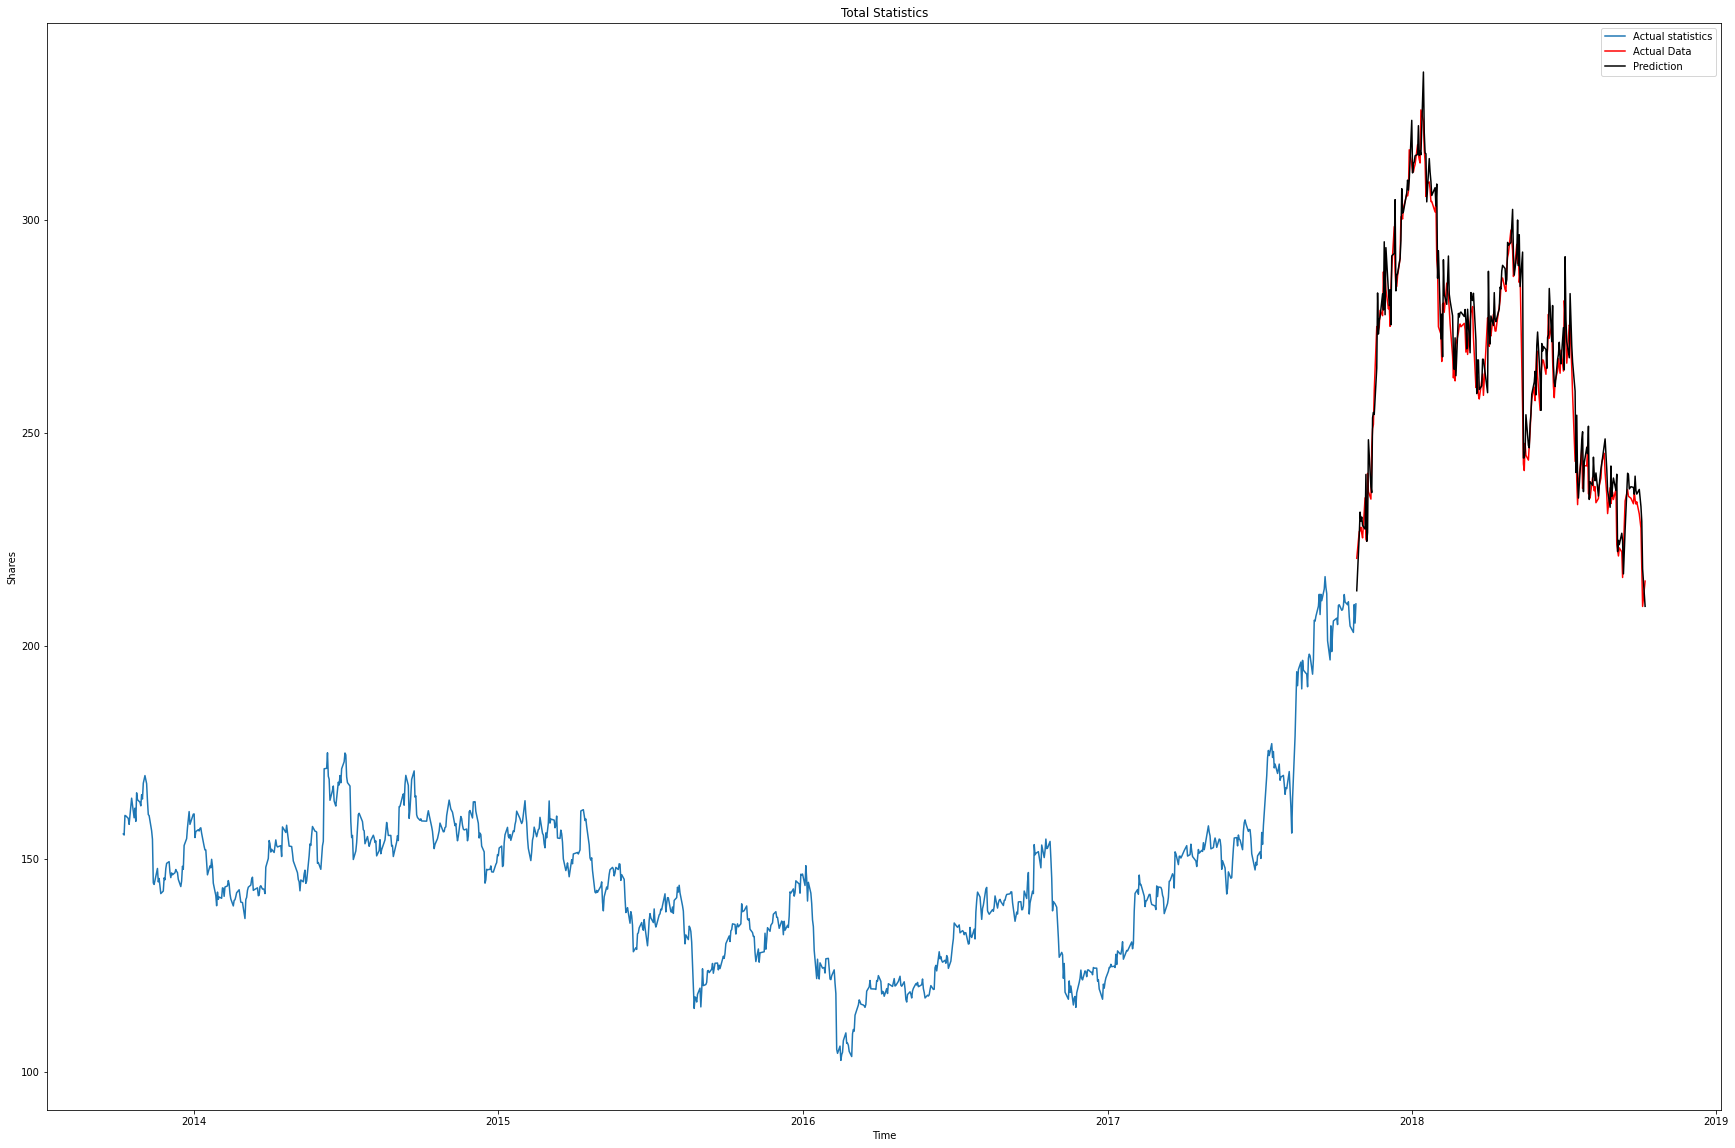

In [ ]:
plt.plot(train['Close'], label="Actual statistics")
plt.plot(valid[['Close']], label="Actual Data", color="red")
plt.plot(valid[['Predictions']], label="Prediction", color="black")

plt.title("Total Statistics")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

## Plotting estimated (prediction graph) for the 'trained value' only

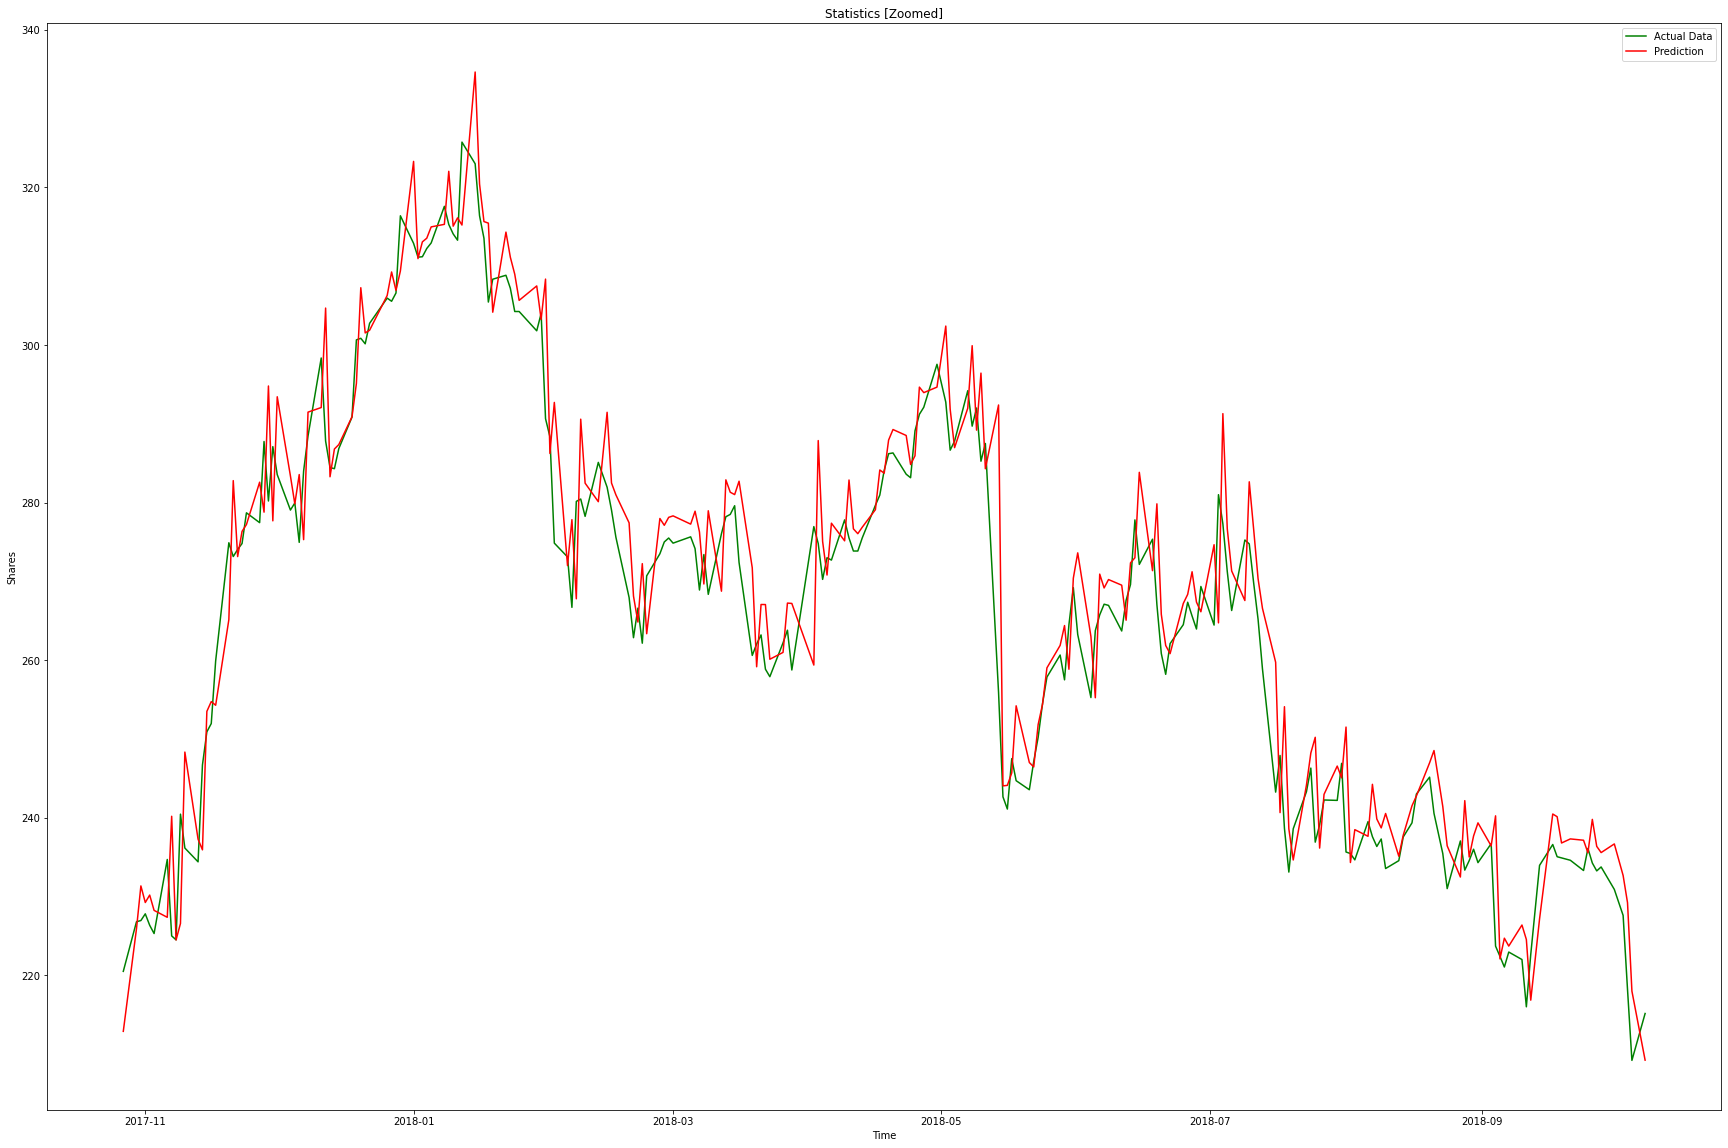

In [ ]:
plt.plot(valid[['Close']], label="Actual Data", color="green")
plt.plot(valid[['Predictions']], label="Prediction", color="red")

plt.title("Statistics [Zoomed]")
plt.xlabel('Time')
plt.ylabel('Shares')
plt.legend()
plt.show()

# Result Metrics for L-S-T-M Method (above)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_test_classes = np.zeros_like(valid['Close'].tolist())
y_test_classes[valid['Close'] > 250] = 1
y_test_classes[valid['Close'] < 200] = -1

y_pred_classes = np.zeros_like(valid['Predictions'].tolist())   
y_pred_classes[valid['Predictions'] > 250] = 1  
y_pred_classes[valid['Predictions'] < 200] = -1
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print('Accuracy: %.3f' % accuracy)

precision = precision_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Precision: %.3f' % precision) 

recall = recall_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('Recall: %.3f' % recall)

score = f1_score(y_test_classes, y_pred_classes, average='macro', zero_division=1)
print('F-Measure: %.3f' % score) 

ME = max_error(valid['Close'], valid['Predictions'])
print('Max-Error: %.3f' % ME) 

MAE = mean_absolute_error(valid['Close'], valid['Predictions'])
print('Mean-Absolute-Error: %.3f' % MAE)

MSE = mean_squared_error(valid['Close'], valid['Predictions'], squared=False)
print('Mean-Squared-Error: %.3f' % MSE) 

AUC = roc_auc_score(y_test_classes, y_pred_classes, average='macro')
print('AUC Score: %.3f' % AUC) 

CM = confusion_matrix(y_test_classes, y_pred_classes)
print("\nConfusion Matrix:\n\n",CM)

Accuracy: 0.932
Precision: 0.934
Recall: 0.907
F-Measure: 0.919
Max-Error: 9914.452
Mean-Absolute-Error: 426.107
Mean-Squared-Error: 2044.565
AUC Score: 0.907

Confusion Matrix:

 [[ 63  12]
 [  4 156]]


# Predict revenue after investments (10000/-) in model, for 10 days

In [ ]:
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Open', 'Close'])

for i in range(0,len(data)):
    new_data['Open'][i] = data['Open'][i]
    new_data['Close'][i] = data['Close'][i]
        
train = new_data[:1000]
valid = new_data[1000:]

c=0
l=[]
for i in range(len(new_data)-1,199,-1):
    if c<10:
        if valid['Open'][i] < valid['Close'][i]:
            valid['Open'][i] += 10000
            l.append(i)
            c+=1
    else: break

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

# Fitting the new set of data
model1.fit(x_train,y_train)
preds = model1.predict(x_valid)

valid['Predictions'] = preds

valid.index = new_data[1000:].index
train.index = new_data[:1000].index

# Appending the prediction-closing value and open value of stocks for the target days, in a list
f=[]
for j in l:
    f.append(valid['Open'][j])
    f.append(valid['Predictions'][j])

s,ss=0,0
for k in range(len(f)):
    if k%2==0: s+=f[k]
    else: ss+=f[k]
print("Stock Revenue %: ",((s-ss)/s)*100)

Stock Revenue %:  0.8329944063997643


# Thank You --------------------------------------------------------------------------------------------------------------------------